<a href="https://colab.research.google.com/github/Tanish-04/Computer-Vision-Projects/blob/master/Image_Segmentation_using_Composable_Fully_Convolutional_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we will be using VGG-19 architecture and extending it further to build 3 versions of differing quality

VGG-19 Architecture Overview:

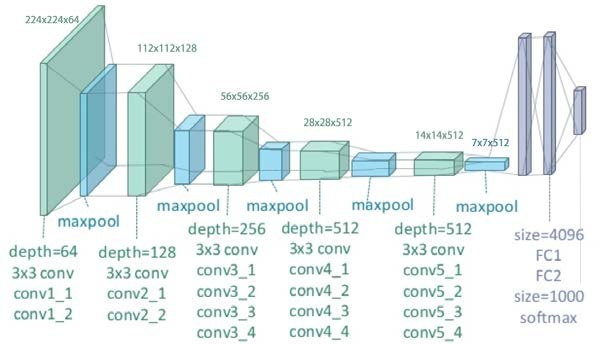


It is an Sequential model which consists of Convolutional blocks, Max-Pooling layers, and fully connected layers.

**Convolutional Blocks:**
Each convolutional block consists of multiple convolutional layers (typically 2 or 3) with the same filter size (usually 3x3) and a fixed stride of 1.

**Max-Pooling Layers:**
Max-pooling layers are inserted after each convolutional block to downsample the feature maps by a factor of 2 (typically with a 2x2 pooling window and stride of 2).

**Fully-Connected Layers:**
At the end of the convolutional blocks, the network transitions to fully-connected layers.

Using the above architecture of VGG-19 as a backbone. We build three different versions of FCN (Fully-Convolutional Networks) of different quality. Different intermediate pooling layers are extracted and processed for different versions.
Below is the updated architecture based on the VGG-19 as backbone

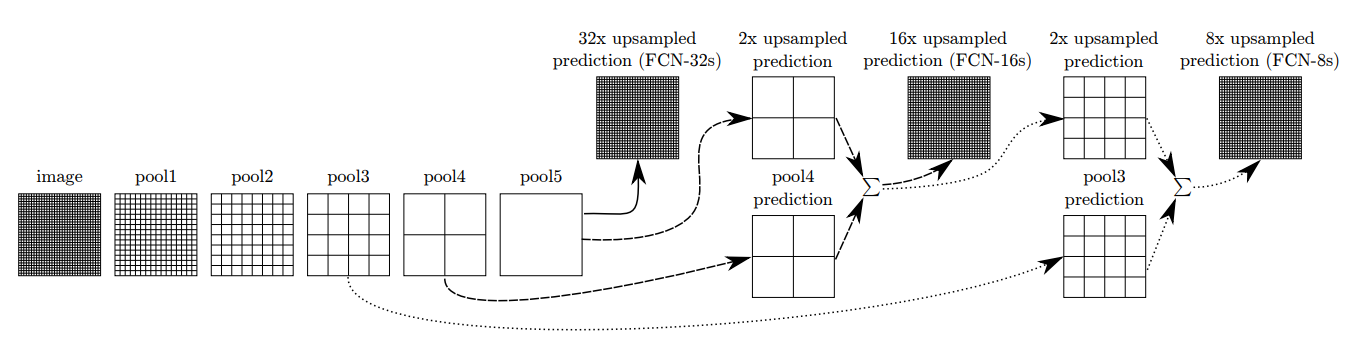

Imports

In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import numpy as np

AUTOTUNE = tf.data.AUTOTUNE

Hyperparameters

In [2]:
NUM_CLASSES = 4
INPUT_HEIGHT = 224
INPUT_WIDTH = 224
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
EPOCHS = 20
BATCH_SIZE = 32
MIXED_PRECISION = True
SHUFFLE = True

# Mixed-precision setting
if MIXED_PRECISION:
    policy = keras.mixed_precision.Policy("mixed_float16")
    keras.mixed_precision.set_global_policy(policy)

Load Dataset

In [3]:
(train_ds, valid_ds, test_ds) = tfds.load(
    "oxford_iiit_pet",
    split=["train[:85%]", "train[85%:]", "test"],
    batch_size=BATCH_SIZE,
    shuffle_files=SHUFFLE,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteIVIZED/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteIVIZED/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [4]:
EPOCHS = 10

Preprocess Data

VGG-19 takes input of size 224 * 224 so resizing both image and segmentation mask of training, testing and validation data.

In [5]:
# Image and Mask Pre-processing
def unpack_resize_data(section):
    image = section["image"]
    segmentation_mask = section["segmentation_mask"]

    resize_layer = keras.layers.Resizing(INPUT_HEIGHT, INPUT_WIDTH)

    image = resize_layer(image)
    segmentation_mask = resize_layer(segmentation_mask)

    return image, segmentation_mask


train_ds = train_ds.map(unpack_resize_data, num_parallel_calls=AUTOTUNE)
valid_ds = valid_ds.map(unpack_resize_data, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(unpack_resize_data, num_parallel_calls=AUTOTUNE)

Visualizing Sample of Pre-Processed data

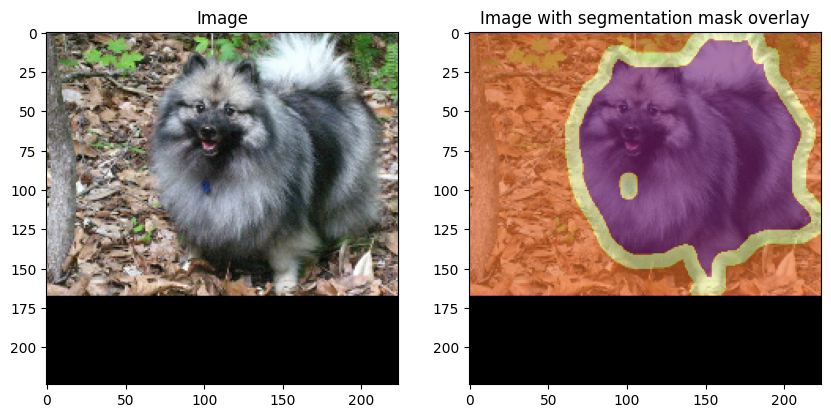

In [6]:
# Select random image and mask. Cast to NumPy array
# for Matplotlib visualization.

images, masks = next(iter(test_ds))
random_idx = tf.random.uniform([], minval=0, maxval=BATCH_SIZE, seed=10)

test_image = images[int(random_idx)].numpy().astype("float")
test_mask = masks[int(random_idx)].numpy().astype("float")

# Overlay segmentation mask on top of image.
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ax[0].set_title("Image")
ax[0].imshow(test_image / 255.0)

ax[1].set_title("Image with segmentation mask overlay")
ax[1].imshow(test_image / 255.0)
ax[1].imshow(
    test_mask,
    cmap="inferno",
    alpha=0.6,
)
plt.show()

*VGG-19 Specific Pre-Processing*


There are two main reasons for using preprocess_input:
- Color Channel Format (RGB to BGR)
- Zero-Centering with ImageNet Statistics

In [7]:
def preprocess_data(image, segmentation_mask):
    image = keras.applications.vgg19.preprocess_input(image)

    return image, segmentation_mask


train_ds = (
    train_ds.map(preprocess_data, num_parallel_calls=AUTOTUNE)
    .shuffle(buffer_size=1024)
    .prefetch(buffer_size=1024)
)
valid_ds = (
    valid_ds.map(preprocess_data, num_parallel_calls=AUTOTUNE)
    .shuffle(buffer_size=1024)
    .prefetch(buffer_size=1024)
)
test_ds = (
    test_ds.map(preprocess_data, num_parallel_calls=AUTOTUNE)
    .shuffle(buffer_size=1024)
    .prefetch(buffer_size=1024)
)

Using VGG-19 as Backbone

In [55]:
input_layer = keras.Input(shape=(INPUT_HEIGHT, INPUT_WIDTH, 3))

# VGG Model backbone with pre-trained ImageNet weights.
vgg_model = keras.applications.vgg19.VGG19(include_top=True, weights="imagenet")

# Extracting different outputs from same model
fcn_backbone = keras.models.Model(
    inputs=vgg_model.layers[1].input,
    outputs=[
        vgg_model.get_layer(block_name).output
        for block_name in ["block3_pool", "block4_pool", "block5_pool"]
    ],
)

# Setting backbone to be non-trainable
fcn_backbone.trainable = False

x = fcn_backbone(input_layer)

# Converting Dense layers to Conv2D layers
units = [4096, 4096]
dense_convs = []

for filter_idx in range(len(units)):
    dense_conv = keras.layers.Conv2D(
        filters=units[filter_idx],
        kernel_size=(7, 7) if filter_idx == 0 else (1, 1),
        strides=(1, 1),
        activation="relu",
        padding="same",
        use_bias=False,
        kernel_initializer=keras.initializers.Constant(1.0),
    )
    dense_convs.append(dense_conv)
    dropout_layer = keras.layers.Dropout(0.5)
    dense_convs.append(dropout_layer)

dense_convs = keras.Sequential(dense_convs)
dense_convs.trainable = False

x[-1] = dense_convs(x[-1])

pool3_output, pool4_output, pool5_output = x

In [31]:
vgg_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

FCN-32S

In [9]:
# 1x1 convolution to set channels = number of classes
pool5 = keras.layers.Conv2D(
    filters=NUM_CLASSES,
    kernel_size=(1, 1),
    padding="same",
    strides=(1, 1),
    activation="relu",
)

# Get Softmax outputs for all classes
fcn32s_conv_layer = keras.layers.Conv2D(
    filters=NUM_CLASSES,
    kernel_size=(1, 1),
    activation="softmax",
    padding="same",
    strides=(1, 1),
)

# Up-sample to original image size
fcn32s_upsampling = keras.layers.UpSampling2D(
    size=(32, 32),
    data_format=keras.backend.image_data_format(),
    interpolation="bilinear",
)

final_fcn32s_pool = pool5(pool5_output)
final_fcn32s_output = fcn32s_conv_layer(final_fcn32s_pool)
final_fcn32s_output = fcn32s_upsampling(final_fcn32s_output)

fcn32s_model = keras.Model(inputs=input_layer, outputs=final_fcn32s_output)

FCN-16S

In [10]:
# 1x1 convolution to set channels = number of classes
# Followed from the original Caffe implementation
pool4 = keras.layers.Conv2D(
    filters=NUM_CLASSES,
    kernel_size=(1, 1),
    padding="same",
    strides=(1, 1),
    activation="linear",
    kernel_initializer=keras.initializers.Zeros())(pool4_output)

# Intermediate up-sample
pool5 = keras.layers.UpSampling2D(
    size=(2, 2),
    data_format=keras.backend.image_data_format(),
    interpolation="bilinear",
)(final_fcn32s_pool)

# Get Softmax outputs for all classes
fcn16s_conv_layer = keras.layers.Conv2D(
    filters=NUM_CLASSES,
    kernel_size=(1, 1),
    activation="softmax",
    padding="same",
    strides=(1, 1),
)

# Up-sample to original image size
fcn16s_upsample_layer = keras.layers.UpSampling2D(
    size=(16, 16),
    data_format=keras.backend.image_data_format(),
    interpolation="bilinear",
)

# Add intermediate outputs
final_fcn16s_pool = keras.layers.Add()([pool4, pool5])
final_fcn16s_output = fcn16s_conv_layer(final_fcn16s_pool)
final_fcn16s_output = fcn16s_upsample_layer(final_fcn16s_output)

fcn16s_model = keras.models.Model(inputs=input_layer, outputs=final_fcn16s_output)

FCN-8S

In [11]:
# 1x1 convolution to set channels = number of classes
# Followed from the original Caffe implementation
pool3 = keras.layers.Conv2D(
    filters=NUM_CLASSES,
    kernel_size=(1, 1),
    padding="same",
    strides=(1, 1),
    activation="linear",
    kernel_initializer=keras.initializers.Zeros(),
)(pool3_output)

# Intermediate up-sample
intermediate_pool_output = keras.layers.UpSampling2D(
    size=(2, 2),
    data_format=keras.backend.image_data_format(),
    interpolation="bilinear",
)(final_fcn16s_pool)

# Get Softmax outputs for all classes
fcn8s_conv_layer = keras.layers.Conv2D(
    filters=NUM_CLASSES,
    kernel_size=(1, 1),
    activation="softmax",
    padding="same",
    strides=(1, 1),
)

# Up-sample to original image size
fcn8s_upsample_layer = keras.layers.UpSampling2D(
    size=(8, 8),
    data_format=keras.backend.image_data_format(),
    interpolation="bilinear",
)

# Add intermediate outputs
final_fcn8s_pool = keras.layers.Add()([pool3, intermediate_pool_output])
final_fcn8s_output = fcn8s_conv_layer(final_fcn8s_pool)
final_fcn8s_output = fcn8s_upsample_layer(final_fcn8s_output)

fcn8s_model = keras.models.Model(inputs=input_layer, outputs=final_fcn8s_output)

Load Weights into backbone

In [12]:
# VGG's last 2 layers
weights1 = vgg_model.get_layer("fc1").get_weights()[0]
weights2 = vgg_model.get_layer("fc2").get_weights()[0]

weights1 = weights1.reshape(7, 7, 512, 4096)
weights2 = weights2.reshape(1, 1, 4096, 4096)

dense_convs.layers[0].set_weights([weights1])
dense_convs.layers[2].set_weights([weights2])

Training

FCN-32S

In [13]:
fcn32s_optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
)

fcn32s_loss = keras.losses.SparseCategoricalCrossentropy()

# Maintain mIOU and Pixel-wise Accuracy as metrics
fcn32s_model.compile(
    optimizer=fcn32s_optimizer,
    loss=fcn32s_loss,
    metrics=[
        keras.metrics.MeanIoU(num_classes=NUM_CLASSES, sparse_y_pred=False),
        keras.metrics.SparseCategoricalAccuracy(),
    ],
)

fcn32s_history = fcn32s_model.fit(train_ds, epochs=EPOCHS, validation_data=valid_ds)

Epoch 1/10
98/98 [==============================] - 96s 356ms/step - loss: 1.1484 - mean_io_u: 0.2161 - sparse_categorical_accuracy: 0.4319 - val_loss: 1.0137 - val_mean_io_u: 0.3260 - val_sparse_categorical_accuracy: 0.6508
Epoch 2/10
98/98 [==============================] - 56s 196ms/step - loss: 0.8826 - mean_io_u: 0.3679 - sparse_categorical_accuracy: 0.6858 - val_loss: 0.8414 - val_mean_io_u: 0.3953 - val_sparse_categorical_accuracy: 0.6976
Epoch 3/10
98/98 [==============================] - 57s 197ms/step - loss: 0.7621 - mean_io_u: 0.3993 - sparse_categorical_accuracy: 0.7117 - val_loss: 0.7564 - val_mean_io_u: 0.4115 - val_sparse_categorical_accuracy: 0.7159
Epoch 4/10
98/98 [==============================] - 53s 201ms/step - loss: 0.7068 - mean_io_u: 0.4153 - sparse_categorical_accuracy: 0.7258 - val_loss: 0.7195 - val_mean_io_u: 0.4274 - val_sparse_categorical_accuracy: 0.7275
Epoch 5/10
98/98 [==============================] - 51s 191ms/step - loss: 0.6790 - mean_io_u: 0.423

FCN-16S

In [14]:
fcn16s_optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
)

fcn16s_loss = keras.losses.SparseCategoricalCrossentropy()

# Maintain mIOU and Pixel-wise Accuracy as metrics
fcn16s_model.compile(
    optimizer=fcn16s_optimizer,
    loss=fcn16s_loss,
    metrics=[
        keras.metrics.MeanIoU(num_classes=NUM_CLASSES, sparse_y_pred=False),
        keras.metrics.SparseCategoricalAccuracy(),
    ],
)

fcn16s_history = fcn16s_model.fit(train_ds, epochs=EPOCHS, validation_data=valid_ds)

Epoch 1/10
98/98 [==============================] - 54s 198ms/step - loss: 1.9662 - mean_io_u_1: 0.5358 - sparse_categorical_accuracy: 0.8025 - val_loss: 1.2401 - val_mean_io_u_1: 0.5950 - val_sparse_categorical_accuracy: 0.8652
Epoch 2/10
98/98 [==============================] - 51s 202ms/step - loss: 1.1273 - mean_io_u_1: 0.5992 - sparse_categorical_accuracy: 0.8779 - val_loss: 1.2101 - val_mean_io_u_1: 0.5995 - val_sparse_categorical_accuracy: 0.8680
Epoch 3/10
98/98 [==============================] - 52s 196ms/step - loss: 1.1070 - mean_io_u_1: 0.6016 - sparse_categorical_accuracy: 0.8796 - val_loss: 1.2240 - val_mean_io_u_1: 0.5950 - val_sparse_categorical_accuracy: 0.8645
Epoch 4/10
98/98 [==============================] - 51s 194ms/step - loss: 0.8488 - mean_io_u_1: 0.6345 - sparse_categorical_accuracy: 0.8706 - val_loss: 0.7274 - val_mean_io_u_1: 0.6413 - val_sparse_categorical_accuracy: 0.8495
Epoch 5/10
98/98 [==============================] - 55s 231ms/step - loss: 0.5924 - 

FCN-8S

In [15]:
fcn8s_optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
)

fcn8s_loss = keras.losses.SparseCategoricalCrossentropy()

# Maintain mIOU and Pixel-wise Accuracy as metrics
fcn8s_model.compile(
    optimizer=fcn8s_optimizer,
    loss=fcn8s_loss,
    metrics=[
        keras.metrics.MeanIoU(num_classes=NUM_CLASSES, sparse_y_pred=False),
        keras.metrics.SparseCategoricalAccuracy(),
    ],
)

fcn8s_history = fcn8s_model.fit(train_ds, epochs=EPOCHS, validation_data=valid_ds)

Epoch 1/10
98/98 [==============================] - 55s 210ms/step - loss: 5.9841 - mean_io_u_2: 0.3143 - sparse_categorical_accuracy: 0.6221 - val_loss: 6.6784 - val_mean_io_u_2: 0.3139 - val_sparse_categorical_accuracy: 0.5806
Epoch 2/10
98/98 [==============================] - 52s 203ms/step - loss: 5.9552 - mean_io_u_2: 0.3162 - sparse_categorical_accuracy: 0.6255 - val_loss: 6.6780 - val_mean_io_u_2: 0.3167 - val_sparse_categorical_accuracy: 0.5796
Epoch 3/10
98/98 [==============================] - 52s 195ms/step - loss: 5.4937 - mean_io_u_2: 0.3529 - sparse_categorical_accuracy: 0.6503 - val_loss: 3.8782 - val_mean_io_u_2: 0.3886 - val_sparse_categorical_accuracy: 0.7430
Epoch 4/10
98/98 [==============================] - 52s 203ms/step - loss: 3.5269 - mean_io_u_2: 0.3883 - sparse_categorical_accuracy: 0.7660 - val_loss: 3.8570 - val_mean_io_u_2: 0.3908 - val_sparse_categorical_accuracy: 0.7454
Epoch 5/10
98/98 [==============================] - 52s 191ms/step - loss: 3.5019 - 

Visualizations

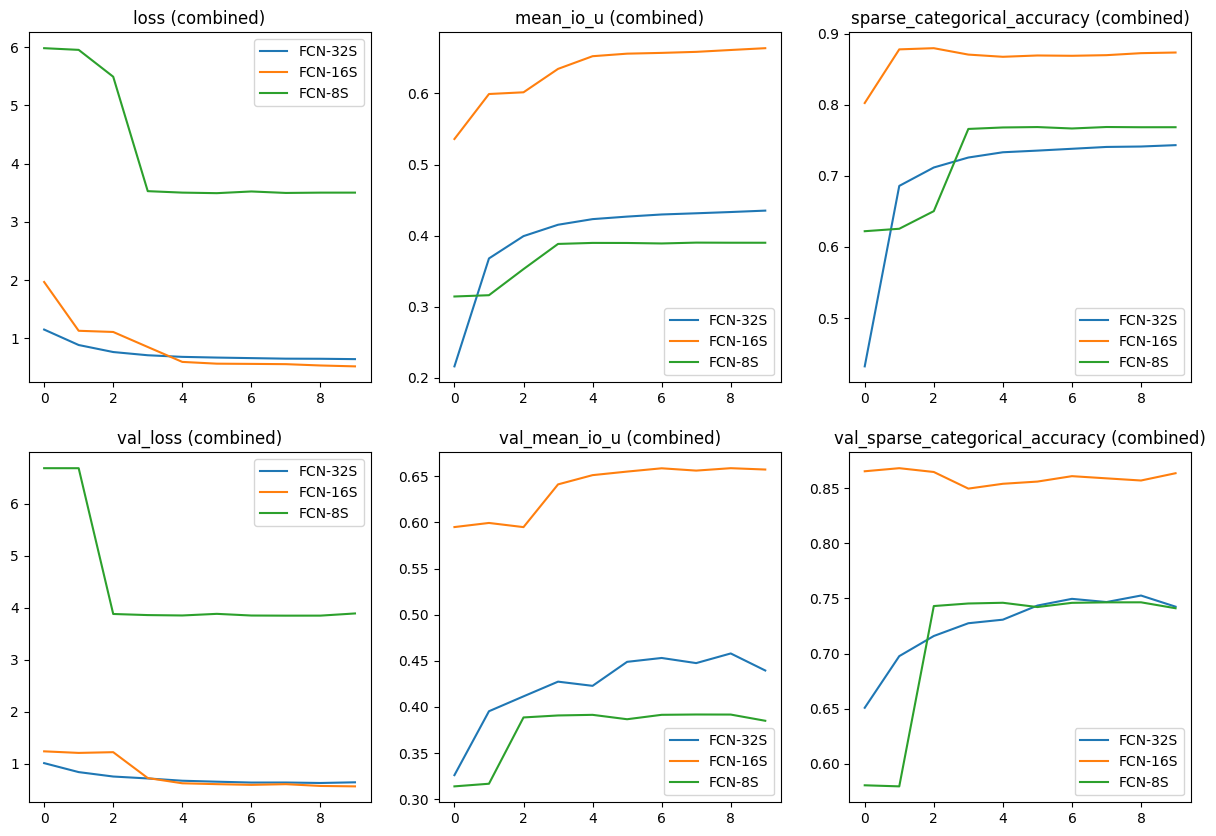

In [16]:
total_plots = len(fcn32s_history.history)
cols = total_plots // 2

rows = total_plots // cols

if total_plots % cols != 0:
    rows += 1

# Set all history dictionary objects
fcn32s_dict = fcn32s_history.history
fcn16s_dict = fcn16s_history.history
fcn8s_dict = fcn8s_history.history

pos = range(1, total_plots + 1)
plt.figure(figsize=(15, 10))

for i, ((key_32s, value_32s), (key_16s, value_16s), (key_8s, value_8s)) in enumerate(
    zip(fcn32s_dict.items(), fcn16s_dict.items(), fcn8s_dict.items())
):
    plt.subplot(rows, cols, pos[i])
    plt.plot(range(len(value_32s)), value_32s)
    plt.plot(range(len(value_16s)), value_16s)
    plt.plot(range(len(value_8s)), value_8s)
    plt.title(str(key_32s) + " (combined)")
    plt.legend(["FCN-32S", "FCN-16S", "FCN-8S"])

plt.show()

Visuals of Predicted Segmentation Masks

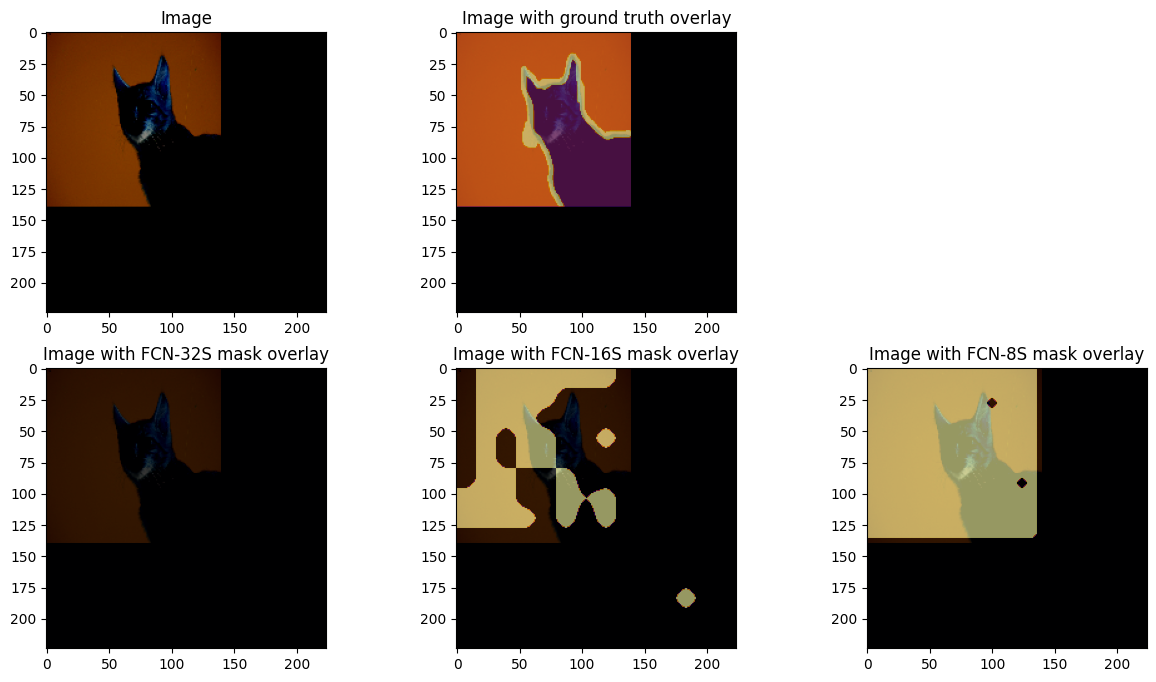

In [19]:
images, masks = next(iter(test_ds))
random_idx = tf.random.uniform([], minval=0, maxval=BATCH_SIZE, seed=10)

# Get random test image and mask
test_image = images[int(random_idx)].numpy().astype("float")
test_mask = masks[int(random_idx)].numpy().astype("float")

pred_image = tf.expand_dims(test_image, axis=0)
pred_image = keras.applications.vgg19.preprocess_input(pred_image)

# Perform inference on FCN-32S
pred_mask_32s = fcn32s_model.predict(pred_image, verbose=0).astype("float")
pred_mask_32s = np.argmax(pred_mask_32s, axis=-1)
pred_mask_32s = pred_mask_32s[0, ...]

# Perform inference on FCN-16S
pred_mask_16s = fcn16s_model.predict(pred_image, verbose=0).astype("float")
pred_mask_16s = np.argmax(pred_mask_16s, axis=-1)
pred_mask_16s = pred_mask_16s[0, ...]

# Perform inference on FCN-8S
pred_mask_8s = fcn8s_model.predict(pred_image, verbose=0).astype("float")
pred_mask_8s = np.argmax(pred_mask_8s, axis=-1)
pred_mask_8s = pred_mask_8s[0, ...]

# Plot all results
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))

fig.delaxes(ax[0, 2])

ax[0, 0].set_title("Image")
ax[0, 0].imshow(test_image / 255.0)

ax[0, 1].set_title("Image with ground truth overlay")
ax[0, 1].imshow(test_image / 255.0)
ax[0, 1].imshow(
    test_mask,
    cmap="inferno",
    alpha=0.6,
)

ax[1, 0].set_title("Image with FCN-32S mask overlay")
ax[1, 0].imshow(test_image / 255.0)
ax[1, 0].imshow(pred_mask_32s, cmap="inferno", alpha=0.6)

ax[1, 1].set_title("Image with FCN-16S mask overlay")
ax[1, 1].imshow(test_image / 255.0)
ax[1, 1].imshow(pred_mask_16s, cmap="inferno", alpha=0.6)

ax[1, 2].set_title("Image with FCN-8S mask overlay")
ax[1, 2].imshow(test_image / 255.0)
ax[1, 2].imshow(pred_mask_8s, cmap="inferno", alpha=0.6)

plt.show()

The results can be improved by increase epochs to 50. Due to hardware limitation I can only run for 10 epochs at my end.